# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = 'traffic-signs-data/train.p'
testing_file = 'traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

# Free memory
del train
del test


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:
### Replace each question mark with the appropriate value.

# TODO: Number of training examples
n_train = X_train.shape[0]

# TODO: Number of testing examples.
n_test = X_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = X_train.shape[1:]

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len( set(y_train) )

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

In [3]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

import cv2

import numpy         as np
import random        as rd
import tensorflow    as tf
import sklearn.utils as sku

from tqdm                    import tqdm
from sklearn.model_selection import train_test_split


In [4]:
def _get_indexes_by_label(labels):
    '''
        return an array of array with all the indexes of this label
    '''
    labels = list(labels) # Ensure we get a python array
    uniq_labels = set(labels)
    
    all_label_idxs = [ [] for i in range(len(uniq_labels)) ]
    for label in uniq_labels:
        all_label_idxs[label] = [i for i in range(len(labels)) if labels[i] == label]

    return all_label_idxs


In [5]:
def display_random_image_of_labels(images, labels, cmap='brg_r'):
    """
        Display a random image of each label.
    """
    all_label_idxs = _get_indexes_by_label(labels)
    plt.figure(figsize=(16, 6))
    i = 1
    for label, label_idxs in enumerate(all_label_idxs):
        # Pick a random image for each label.
        image = images[label_idxs[rd.randint(0,len(label_idxs)-1)]]
        plt.subplot(4, 11, i)  
        plt.axis('off')
        plt.title('Label {}'.format(label))
        i += 1
        plt.imshow(image, cmap)
    plt.show()

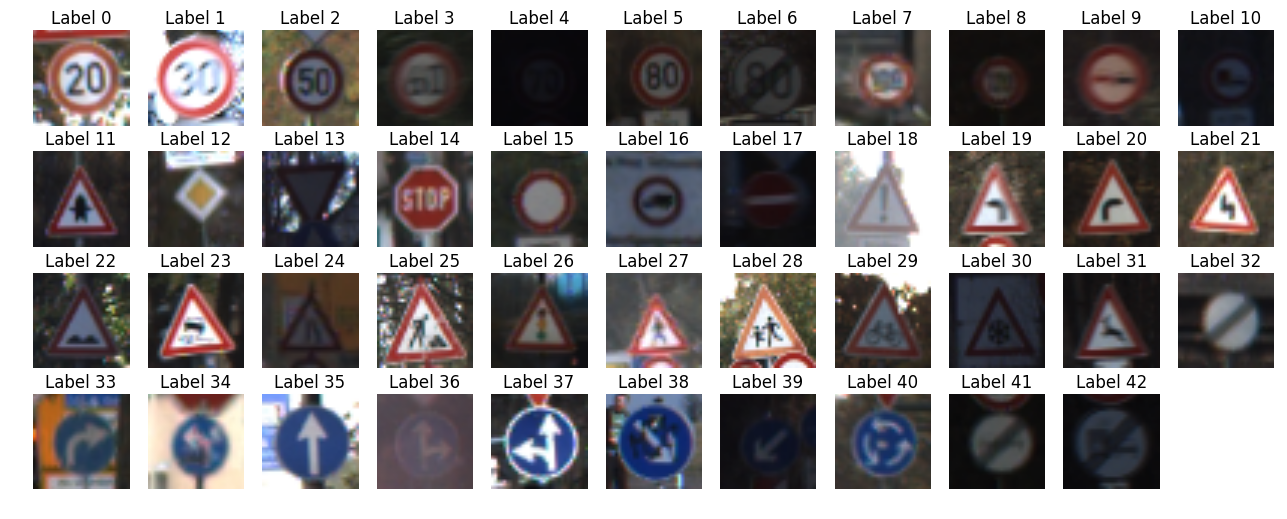

In [6]:
# Display images of our Training dataset
display_random_image_of_labels(X_train, y_train)



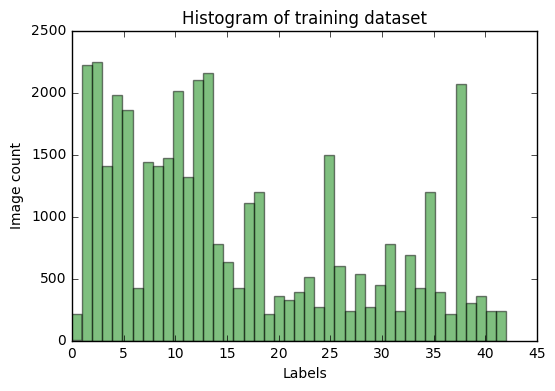

In [7]:
# the histogram of the training data set repartition
# we can see that there is not an equal number of examples by class
# It range from about 200 to 2250, so we will need to generate data
plt.hist(y_train, n_classes, facecolor='green', alpha=0.5)
plt.xlabel('Labels')
plt.ylabel('Image count')
plt.title('Histogram of training dataset')
plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [8]:
def convert_to_grayscale(images):
    '''
        Convert the images set to grayscale
    '''
    # Convert all images to grayscale
    #return np.mean(images, axis=3)
    return np.array([cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) for img in images])
 
 
def equalize_images(images):
    '''
        Images are assumed to be in grayscale
        Equalize the image to improve contrast
        Return an numpy array with the images
    '''
    # Used an adataptive histogram equalization
    clahe = cv2.createCLAHE(clipLimit=2, tileGridSize=(3,3))
    return np.array([ clahe.apply(img) for img in images ])

def preprocess_images(images):
    '''
        Preprocess the images :
             - Convert to grayscale
             - equalize and normalize
             - center them to origin so the mean is zero
    '''
    
    images = equalize_images(convert_to_grayscale(images))
    
    
    # Normalize images in [0.0,1.0]
    images = images / 255
    
    # center at origin and zero mean
    # This is to ease the gradient descent process
    images -= np.mean(images)
    
    return images


In [9]:
# Prepropress all datasets
X_train = preprocess_images(X_train)
X_test  = preprocess_images(X_test)



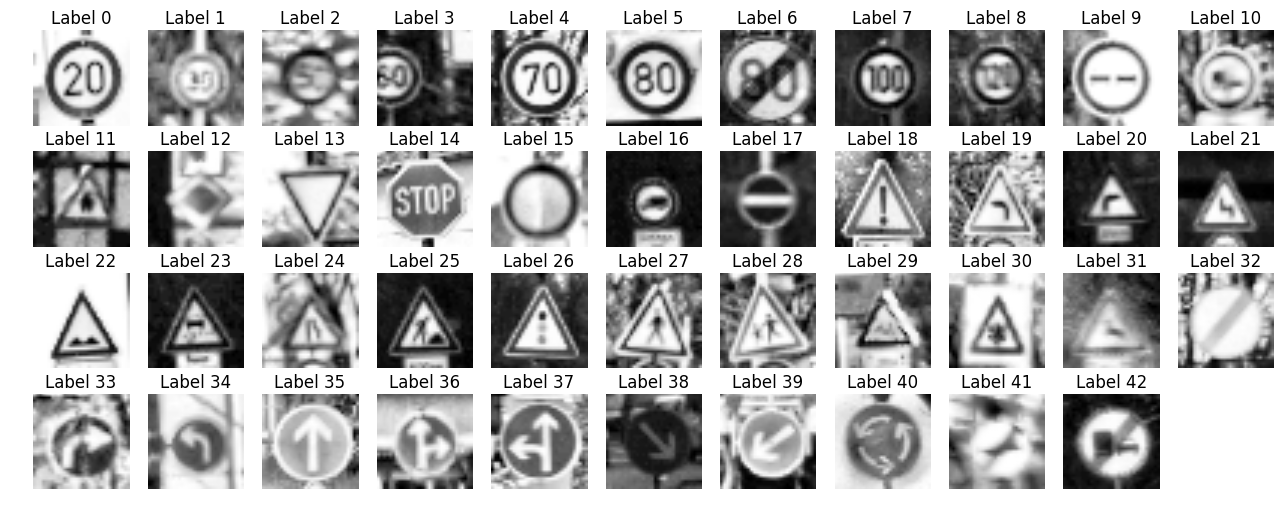

In [10]:
# Display images of our Training dataset after prepocessing
display_random_image_of_labels(X_train, y_train, cmap='Greys_r')


### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

#### Convertion to grayscale :

- Reduce the data to process for the neural network, we only have one channel instead of three.So it reduces the computation time, even if we may lose some informations. But all the signs can be clearly identified by the shape, no two signs need to be identified by colors
- It is simplier to handle, it ease the affine transformation that we will need to generate additional data

#### Equalization :
- I Used and adataptive histogram equalization to reinforce the contrast as some images had really low contrast and it was really difficult to see the sign

#### Normalization :
- I normalize the data in the range [0.0-1.0] so the standard deviation of our image is low to ease the gradient descent process
      
#### Zero Mean :
- I substract the mean of the images to center them at the origin and get a zero mean. This will as well help the gradient descent process
      
#### Possible improvement :
- Increase the edges to have stonger features.
- Add some tearing, streching along different axis to simulate deformation from diffrent camera angles
- Add some layer of different shape ( circle, rectangle, hexagon, ...) to simulate the sign hidden by shadow or even damaged

In [11]:
def train_validation_split(images, labels):
    '''
        Generate a validation dataset by taking 45 images randomly by labels
        
        return the input dataset shrinked and the validation set
    '''
    # Get all indexes organized by label
    all_label_idxs = _get_indexes_by_label(labels)
   
    validation_images = []
    validation_labels = []
    all_idxs = []
    # Generate additional data by labels
    for label_idxs in all_label_idxs:
        # Get a sample from this label
        idxs = rd.sample(label_idxs, 45)
        
        # Add those images to the validation set
        validation_images.extend(images[idxs])
        validation_labels.extend(labels[idxs])
        all_idxs.extend(idxs)

    
    # Remove all validation images from the input dataset
    images = np.delete(images, all_idxs, axis=0)
    labels = np.delete(labels, all_idxs, axis=0)
        
    # Return the split
    return images, np.array(validation_images),labels, np.array(validation_labels)

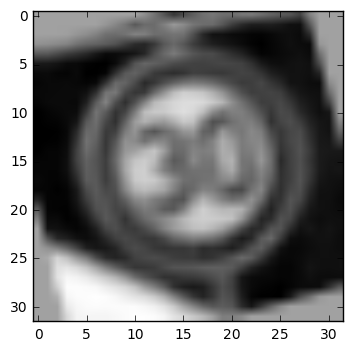

In [12]:
def rotate_image(image, angle):
    '''
        Rotate an image by angle in degree
    '''
    height, width = image.shape[0:2]
    
    # Rotation matrix on center point of the image
    M = cv2.getRotationMatrix2D((width/2,height/2),angle,1)
    
    return cv2.warpAffine(image,M, image.shape[0:2])

plt.imshow(rotate_image(X_train[600],15), cmap='Greys_r')
plt.show()

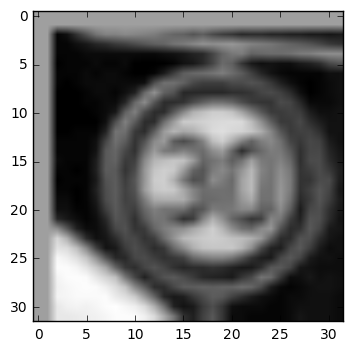

In [13]:
def translate_image(image, tx=0, ty=0):
    '''
        Translate an image by (tx, ty) 
    '''

    # Translation matrix
    M = np.array([ [ 1.0, 0.0, tx]
                  ,[ 0.0, 1.0, ty]
                 ])
    
    return cv2.warpAffine(image,M,image.shape[0:2])

plt.imshow(translate_image(X_train[600],2,2), cmap='Greys_r')
plt.show()

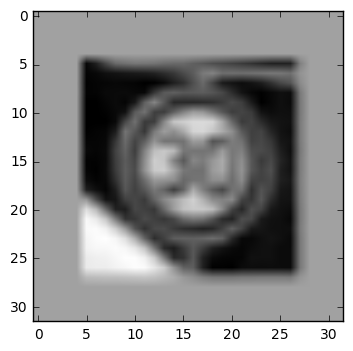

In [14]:
def scale_image(image, s=1.0):
    '''
        Scale an image by s
    '''
    height, width = image.shape[0:2]
    
    # Scaling matrix on center point of the image
    M = cv2.getRotationMatrix2D((width/2,height/2),0,s)
    
    return cv2.warpAffine(image,M,image.shape[0:2])

plt.imshow(scale_image(X_train[600],0.7), cmap='Greys_r')
plt.show()

In [15]:
def generate_additional_images(images, labels):
    '''
        Generate additional data to get the same number of example by labels
        Create up additional images by rotation/translation/scaling from the original image
    '''
    # Get all indexes organized by label
    all_label_idxs = _get_indexes_by_label(labels)
    
    # Max number of image in the dataset
    max_count = np.max([ len(i) for i in all_label_idxs])
    
    gen_images = []
    gen_labels = []
    # Generate additional data by labels
    for label_idxs in all_label_idxs:
        # Number of images generate, minumun 500 new images
        n_img_to_generate = max(500, max_count - len(label_idxs))

        # Go over the list of images, shuffle it to avoid getting
        # close images
        rd.shuffle(label_idxs)
        for idx in label_idxs:
            # Generate at 8 new images from original if any to do
            if n_img_to_generate > 0:
                n_img_to_generate -= 8

                # Generate 4 new images by rotation in the range [-15, +15] by 2 deg steps
                for angle in rd.sample(range(-15,16,2), 4):
                    gen_images.append( rotate_image(images[idx], angle) )
                    gen_labels.append( labels[idx] )
                    
                # Generate 2 new images by translation in [-2,2] in both direction
                txs = rd.sample([-2,-1,1,2], 2)
                tys = rd.sample([-2,-1,1,2], 2)
                for tx,ty in zip(txs, tys):
                    gen_images.append( translate_image(images[idx], tx, ty) )
                    gen_labels.append( labels[idx] )
                        
                # Generate 2 new images by scaling in [0.8,1.2] in 0.02 steps
                for scale in rd.sample(range(80,120,2), 2):
                    gen_images.append( scale_image(images[idx], scale / 100 ) )
                    gen_labels.append( labels[idx] )
                        
    # Return
    return gen_images, gen_labels

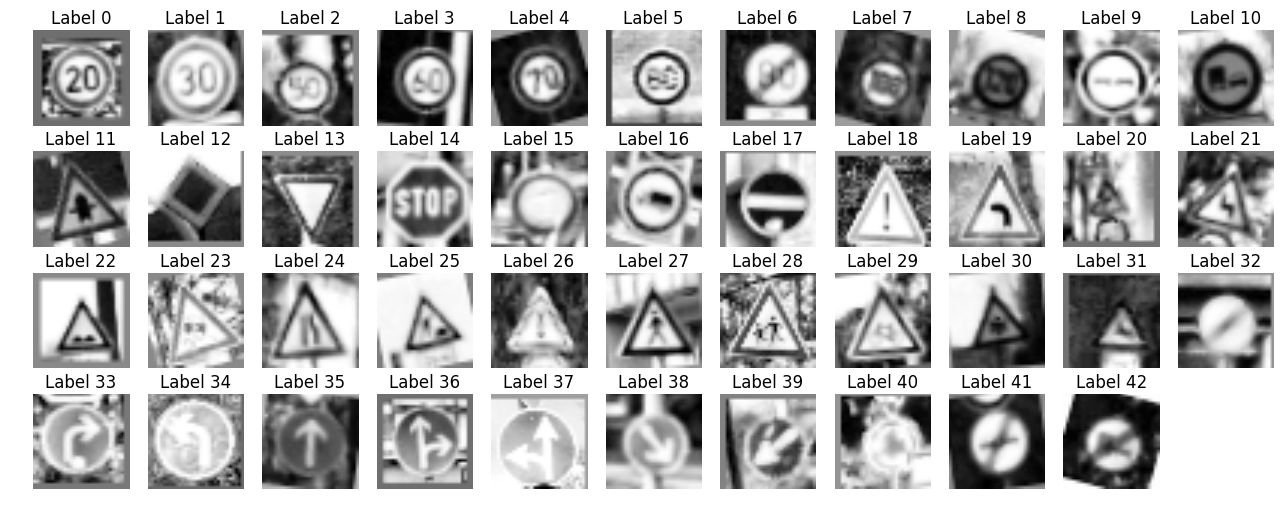

In [16]:
# Generate additional images
X_train_additional, y_train_additional = generate_additional_images(X_train, y_train )

display_random_image_of_labels(X_train_additional, y_train_additional, cmap='Greys_r')



In [17]:
# Add those new images to the training set
X_train = np.concatenate( (X_train, X_train_additional) )
y_train = np.concatenate( (y_train, y_train_additional) )

# Free memory
del X_train_additional
del y_train_additional

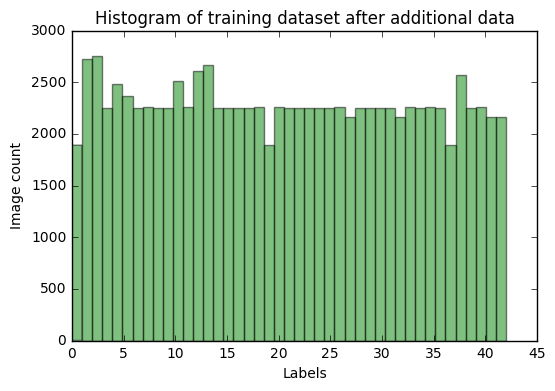

In [18]:
# Now all the classes have roughly the same number of images
plt.hist(y_train, n_classes, facecolor='green', alpha=0.5)
plt.xlabel('Labels')
plt.ylabel('Image count')
plt.title('Histogram of training dataset after additional data')
plt.show()

In [19]:
# Split the training set between training and validation
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=832289)


In [20]:
# Reshape the datasets so we have a 4D shape, required for the convulution network
X_train = np.reshape(X_train, (-1,X_train[0].shape[0],X_train[0].shape[1],1))
X_valid = np.reshape(X_valid, (-1,X_valid[0].shape[0],X_valid[0].shape[1],1))
X_test  = np.reshape(X_test , (-1,X_test[0].shape[0] ,X_test[0].shape[1] ,1))

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

#### Datasets Setup:
- In order to adjust the hyperparameters and doing validation, i splitted the training dataset in 2 parts. I splitted in a ratio of 0.2 for the validation so it has almost the same size as the test dataset.
- I didn't have to generate a test dataset, it was already provided.
    
#### Additional data:
- As we can see in the repartition graph of the training dataset, the dataset is well unbalanced. So to avoid bias in the classifier, i generated additional data to have a more balance dataset. This will also built a more robust network on potential deformation from real life data.
- For each label we are generating additional images up to the maximum existing in the dataset with a minimun of 500.
- To generate those images,i generate 8 new images from randomized image selected in original dataset. The repartition is 4 rotation, 2 translation and 2 scaling. Each operation use randomized parameters from the range [-15,15] for rotation, [-2,2] for translation in both axis, [0.8,1.2] for scaling.

In [21]:
# Dict to store the configuration of each components of the network
def relu_config():
    return {'type': 'relu'} 

def flatten_config():
    return {'type': 'flatten'}

def dropout_config(keep_prob):
    '''
        Build a config dict for a dropout layer
    '''
    return { 'type'       : 'dropout'
            ,'keep_prob'  : keep_prob
           }

def max_pool_config(ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID'):
    '''
        Build a config dict for a max pool layer
    '''
    return { 'type'   : 'max_pool'
            ,'ksize'  : ksize
            ,'strides': strides
            ,'padding': padding  
           }

def avg_pool_config(ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID'):
    '''
        Build a config dict for an average pool layer
    '''
    return { 'type'   : 'avg_pool'
            ,'ksize'  : ksize
            ,'strides': strides
            ,'padding': padding  
           }

def convolution_config(ksize=[5,5], depth_out=8, strides=[1,1,1,1], padding='VALID', sigma=0.001):
    '''
        Build a config dict for a convolution layer
    '''
    return { 'type'      : 'convolution'
            ,'ksize'     : ksize
            ,'depth_out' : depth_out
            ,'strides'   : strides
            ,'padding'   : padding  
            ,'sigma'     : sigma
           }

def fully_connected_config(depth_out=128, sigma=0.001):
    '''
        Build a config dict for a fully connected layer
    '''
    return { 'type'      : 'fully_connected'
            ,'depth_out' : depth_out
            ,'sigma'     : sigma
           }

def build_layer(config, tfx, layer_num):
    '''
        Build a tensor flow from the config provided
        Used the tensor flow tfx as input
    '''
    layer_type = config['type']
    
    if   layer_type == 'relu':
        return tf.nn.relu(tfx)
    elif layer_type == 'flatten':
        return tf.contrib.layers.flatten(tfx)
    elif layer_type == 'dropout':
        return tf.nn.dropout(tfx, keep_prob=config['keep_prob'])
    elif layer_type == 'max_pool':
        return tf.nn.max_pool(tfx, ksize=config['ksize'], strides=config['strides'], padding=config['padding'])
    elif layer_type == 'avg_pool':
        return tf.nn.avg_pool(tfx, ksize=config['ksize'], strides=config['strides'], padding=config['padding'])
    elif layer_type == 'convolution':
        # Get the shape of our weights
        w_shape = config['ksize'] # Kernel size
        w_shape.append(tfx.get_shape().as_list()[-1]) # Input depth
        w_shape.append(config['depth_out']) # Output depth
        
        conv_W = tf.Variable(  tf.truncated_normal( shape=w_shape, stddev=config['sigma']) \
                             , name='conv_W_{:d}'.format(layer_num) \
                            )
        conv_B = tf.Variable( tf.zeros(config['depth_out']), name='conv_B_{:d}'.format(layer_num))
        return tf.nn.conv2d(tfx, conv_W, strides=config['strides'], padding=config['padding']) + conv_B
    elif layer_type == 'fully_connected':
        fc_W = tf.Variable(  tf.truncated_normal( shape=(tfx.get_shape().as_list()[-1], config['depth_out']), stddev=config['sigma']) \
                           , name='fc_W_{:d}'.format(layer_num) \
                          )
        fc_B = tf.Variable(tf.zeros(config['depth_out']), name='fc_B_{:d}'.format(layer_num) )
        return tf.matmul(tfx, fc_W) + fc_B
        

def layer_num():
    '''
        functor to simulate static variable
    '''
    try:
        layer_num.counter += 1
    except AttributeError:
        layer_num.counter = 1
    return layer_num.counter

def build_network(configs, tfx):
    '''
        Build a tensor flow network from the configs provided
        Used the tensor flow tfx as input
        By default all layers are sequential, to have a parallel subnetwork, use the keyword 'parallel'
        as the 1st element of the array, and the axis of concatenation in second element
        Also you can use  the keyword 'concat' to concat the current tensor flow with the out from the next item
        in the list, and the axis of concatenation in second element
    '''
    layer = tfx
    for config in configs:
        if isinstance(config, list):
            # We have a sub network, so recurse
            layer = build_network(config, layer)
        else:
            if config == 'parallel':
                # In parallel, must have subnetwork, so recurse in each of them and concat the outputs
                #para = [build_network(sp, layer) for sp in configs[2:]]
                #print(para)
                return tf.concat_v2(values=[build_network(sp, layer) for sp in configs[2:]], axis=configs[1])
            elif config == 'concat':
                return tf.concat_v2(values=[layer, build_network(configs[2:], layer)], axis=configs[1])
            
            # Final layer spec
            layer = build_layer(config, layer, layer_num())
    return layer
    



In [22]:
def get_LeNet_network_config(nb_classes, conv_depths=[6,16], hfc_depths=[120,84], sigma=0.01, add_dropout=False, keep_prob=None):
    """
        Define a CNN that follow LeNet architecture
        
        It is creating the following network
       
        [CONV -> ACT -> POOL]... -> [HFC]... -> FC
        
        Input paramaters
        nb_classes : A number of output classes
        conv_depths: An array to generate the convolution layers ksize=[5,5] strides[1,1] padding='VALID'
                     Each value in the array will generate a layer with that depth
                     + a max pool ksize=[2,2] strides=[2,2]
        hfc_depths : An array to generate the hidden fully connected layers
                     Each value in the array will generate a layer with that depth
        sigma      : The standard deviation used to initialize parameters
        add_dropout: Add a dropout layer after convolution and hidden fully connected layer
        keep_prod  : Used in conjonction with add_dropout to define keep probability of dropout layer
    """
    
    config=[]
    
    # Convolution layers
    for conv_depth in conv_depths:
        config.append(convolution_config(ksize=[5,5], depth_out=conv_depth, strides=[1,1,1,1], padding='VALID', sigma=sigma))
        config.append(relu_config())
        config.append(max_pool_config())
    
    if add_dropout:
        config.append(dropout_config(keep_prob))
    
    # Then  flatten for the fully connected layers
    config.append(flatten_config())
    
    # Fully connected layers
    for hfc_depth in hfc_depths:
        config.append(fully_connected_config(depth_out=hfc_depth, sigma=sigma))
        config.append(relu_config())
    
    if add_dropout:
        config.append(dropout_config(keep_prob))

    # Output fully connected layer
    config.append(fully_connected_config(depth_out=nb_classes, sigma=sigma))
    
    return config
        

In [23]:
def inception_config(depth_out=128):
    '''
        Defined the configuration of an inception module
        This is multiple convolution in parallel
        
        depth_out define the detph of the combined convolution
    '''
    
    sigma = 0.01
    config = ['parallel', 3]
    
    # AVGPOOL -> CONV 1x1 : 1/8 of the depth out
    config.append([ avg_pool_config(ksize=[1,2,2,1], strides=[1,1,1,1], padding='SAME')
                   ,convolution_config(ksize=[1,1], depth_out=depth_out//8, strides=[1,1,1,1], padding='SAME', sigma=sigma)
                  ]
                 )
    
    # CONV 1x1 : 1/4 of the depth out
    config.append([convolution_config(ksize=[1,1], depth_out=depth_out//4, strides=[1,1,1,1], padding='SAME', sigma=sigma)])
    
    # CONV 1x1 -> CONV 3x3 : 1/2 of the depth_out
    config.append([ convolution_config(ksize=[1,1], depth_out=depth_out//4, strides=[1,1,1,1], padding='SAME', sigma=sigma)
                   ,convolution_config(ksize=[3,3], depth_out=depth_out//2, strides=[1,1,1,1], padding='SAME', sigma=sigma)
                  ]
                 )

    # CONV 1x1 -> CONV 5x5 : 1/8 of the depth_out
    config.append([ convolution_config(ksize=[1,1], depth_out=depth_out//16, strides=[1,1,1,1], padding='SAME', sigma=sigma)
                   ,convolution_config(ksize=[5,5], depth_out=depth_out//8, strides=[1,1,1,1], padding='SAME', sigma=sigma)
                  ]
                 )
    return config

In [24]:
def get_goodLeNetIsh_network_config(nb_classes, sigma=0.01, keep_prob=None):
    
    return [ 
                convolution_config(ksize=[3,3], depth_out=16, strides=[1,1,1,1], padding='SAME', sigma=sigma)
              , convolution_config(ksize=[3,3], depth_out=64, strides=[1,1,1,1], padding='SAME', sigma=sigma)
              , relu_config()
              , max_pool_config()
              , dropout_config(keep_prob)
        
              , inception_config(128)
              , relu_config()
              , max_pool_config()
        
              , inception_config(256)
              , relu_config()
              , max_pool_config()
              , dropout_config(keep_prob)
        
              , flatten_config()
            
              , fully_connected_config(depth_out=256, sigma=sigma)
              , relu_config()
              , dropout_config(keep_prob)

              , fully_connected_config(depth_out=nb_classes, sigma=sigma)
           ]
    

In [25]:
# Network inputs

# The image is be 32x32x1
x = tf.placeholder(tf.float32, (None, 32, 32, 1))

# Classify over n_classes traffic signs
y = tf.placeholder(tf.int32, (None))
y_one_hot = tf.one_hot(y, n_classes)

# Dropout probability
keep_prob = tf.placeholder(tf.float32)



In [26]:
# Define the network
SIGMA=0.1

network_config = get_LeNet_network_config(n_classes, conv_depths=[60,100], hfc_depths=[200,100]
                                          , sigma=SIGMA
                                          , add_dropout=True, keep_prob=keep_prob)
#network_config = get_goodLeNetIsh_network_config(n_classes, sigma=SIGMA, keep_prob=keep_prob)


logits = build_network(network_config, x)


### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

My final design used a LeNet architecture with 2 convolutions layers of 60 and 100 in depth respectively. Each convolution layer use a ReLu activation and a max pooling.

Those layers are followed by 2 hidden fully connected layer of 200 and 100 in depth respectively. Each hidden fully connected layer use a ReLu activation.

Then the output layer is a fully connected of 43 in depth.

There dropout layer after the convolutions and after the hidden fully connected layer.

This architecture achieve an accuray of 99.80% on validation dataset and **97.05%** on test dataset

Here is a diagram of the architecture

![Architecture diagram](./notebook_data/Network_architecture.png)


In [27]:
# Configuration hyperparameters
EPOCHS        = 20
BATCH_SIZE    = 32
LEARNING_RATE = 0.001
KEEP_PROB     = 0.5


In [28]:
# Prediction
prediction = tf.nn.softmax(logits)

#loss operation using the cross entropy
loss_op = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits(logits, y_one_hot))

# To train we minimize the loss
train_op = tf.train.AdamOptimizer(learning_rate = LEARNING_RATE, name='Adam_0').minimize(loss_op)

# Accuracy definition
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y_one_hot, 1))
accuracy_op = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


In [29]:
def evaluate_data(X_dataset, y_dataset, sess):
    """
    Given a dataset as input returns the loss and accuracy.
    """
    n_data      = len(X_dataset)
    n_batches   = n_data // BATCH_SIZE
    n_remaining = n_data % BATCH_SIZE
    
    #batches_pbar = tqdm(range(n_batches), desc='Validation ', unit='batches')

    # Loop on all batches
    total_loss, total_acc = 0.0, 0.0
    for batch_i in range(n_batches): #batches_pbar:
        # Get the batch of features and labels
        b_start = batch_i * BATCH_SIZE
        batch_x = X_dataset[b_start:b_start+BATCH_SIZE]
        batch_y = y_dataset[b_start:b_start+BATCH_SIZE]

        loss, acc = sess.run([loss_op,accuracy_op] , feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_loss += (loss * BATCH_SIZE)
        total_acc  += (acc  * BATCH_SIZE)

    # Remaining data if any
    if n_remaining != 0:
        b_start = n_batches * BATCH_SIZE
        batch_x = X_dataset[b_start:]
        batch_y = y_dataset[b_start:]

        loss, acc = sess.run([loss_op,accuracy_op] , feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_loss += (loss * n_remaining)
        total_acc  += (acc  * n_remaining)

        
    return total_loss / n_data, total_acc  / n_data
        

In [30]:
import os.path

save_file = './model.ckpt'
saver = tf.train.Saver()

t_loss_epochs = []
v_loss_epochs = []
vacc_epochs = []

with tf.Session() as sess:
    sess.run( tf.global_variables_initializer() )
    #saver.restore(sess, save_file)
    
    n_train_batches = len(X_train) // BATCH_SIZE
    
    max_valid_acc = 0
    
    for epoch_i in range(EPOCHS):
        
        X_train,y_train = sku.shuffle(X_train, y_train)
        # Progress bar
        #batches_pbar = tqdm(range(n_train_batches), desc='Epoch-T  {:>2}/{}'.format(epoch_i+1, EPOCHS), unit='batches')
    
        # Training cycle
        for batch_i in range(n_train_batches): #batches_pbar:
            # Get the batch of training and labels
            b_start = batch_i * BATCH_SIZE
            batch_x = X_train[b_start:b_start+BATCH_SIZE]
            batch_y = y_train[b_start:b_start+BATCH_SIZE]
            
            sess.run(train_op, feed_dict={x: batch_x, y: batch_y, keep_prob: KEEP_PROB})

        # Eval the accuracy on training
        #total_train_loss, total_train_acc = evaluate_data(X_train, y_train, sess)
        #t_loss_epochs.append(total_train_loss)                
        
        # Eval the accuracy on validation
        total_valid_loss, total_valid_acc = evaluate_data(X_valid, y_valid, sess)
        v_loss_epochs.append(total_valid_loss)
        vacc_epochs.append(total_valid_acc)
        max_valid_acc = max(max_valid_acc, total_valid_acc)

        #print('E {} => TL={:.6f} TA={:.6f} VL={:.6f} VA={:.6f} MVA={:.6f}'.format(epoch_i,total_train_loss, total_train_acc, total_valid_loss, total_valid_acc, max_valid_acc))
        print('Epoch {:3} => V Loss={:.6f} V Accuracy={:.6f} Max VA={:.6f}'.format(epoch_i+1, total_valid_loss, total_valid_acc, max_valid_acc))
        #
        if os.path.isfile('./stop_training'):
            print('Interruped by user')
            break
                    
    saver.save(sess, save_file)
 

Epoch   1 => V Loss=0.128924 V Accuracy=0.960546 Max VA=0.960546
Epoch   2 => V Loss=0.049507 V Accuracy=0.985320 Max VA=0.985320
Epoch   3 => V Loss=0.024944 V Accuracy=0.992915 Max VA=0.992915
Epoch   4 => V Loss=0.026101 V Accuracy=0.993424 Max VA=0.993424
Epoch   5 => V Loss=0.015947 V Accuracy=0.995871 Max VA=0.995871
Epoch   6 => V Loss=0.020162 V Accuracy=0.995158 Max VA=0.995871
Epoch   7 => V Loss=0.015344 V Accuracy=0.996585 Max VA=0.996585
Epoch   8 => V Loss=0.018870 V Accuracy=0.995208 Max VA=0.996585
Epoch   9 => V Loss=0.016419 V Accuracy=0.996585 Max VA=0.996585
Epoch  10 => V Loss=0.013800 V Accuracy=0.997553 Max VA=0.997553
Epoch  11 => V Loss=0.015393 V Accuracy=0.996687 Max VA=0.997553
Epoch  12 => V Loss=0.011049 V Accuracy=0.998012 Max VA=0.998012
Epoch  13 => V Loss=0.011655 V Accuracy=0.996993 Max VA=0.998012
Epoch  14 => V Loss=0.014090 V Accuracy=0.997247 Max VA=0.998012
Epoch  15 => V Loss=0.017173 V Accuracy=0.995820 Max VA=0.998012
Epoch  16 => V Loss=0.012

In [31]:
# Evaluate the network on the test dataset
save_file = './model.ckpt'
saver = tf.train.Saver()

label_predictions =[]

with tf.Session() as sess:
    # Restore our model
    saver.restore(sess, save_file)
    # Eval the accuracy on test dataset 
    loss, acc = evaluate_data(X_test, y_test, sess)
    print("Test data => Loss={:.6f} Accuracy={:.4f}".format(loss, acc))

    n_test_batches = len(X_test) // BATCH_SIZE
    # Prediction cycle
    for batch_i in range(n_test_batches):
        b_start = batch_i * BATCH_SIZE
        batch_x = X_test[b_start:b_start+BATCH_SIZE]

        pred = sess.run(prediction, feed_dict={x: batch_x, keep_prob: 1.0})
        label_predictions.extend(pred)

    pred = sess.run(prediction, feed_dict={x: X_test[b_start+BATCH_SIZE:], keep_prob: 1.0})
    label_predictions.extend(pred)
        

Test data => Loss=0.220324 Accuracy=0.9705


In [32]:
def plot_confusion_matrix(cm, normalize=False, title='Confusion matrix', cmap=plt.cm.Greens):
    """
    This function plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


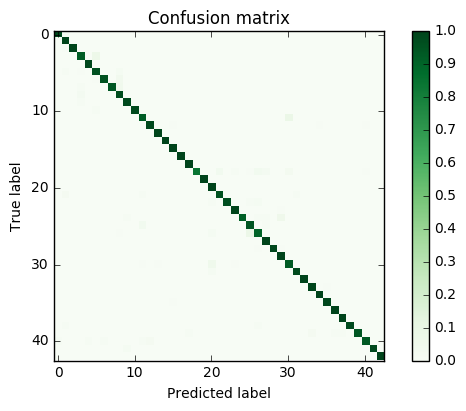

In [33]:
from sklearn.metrics import confusion_matrix

pred_label = np.argmax(label_predictions,axis=1)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, pred_label)

# Plot normalized confusion matrix
plot_confusion_matrix(cnf_matrix, normalize=True)


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

    OPTIMIZER     = Adam
    EPOCHS        = 20
    BATCH_SIZE    = 32
    LEARNING_RATE = 0.001
    KEEP_PROB     = 0.5
    SIGMA         = 0.1


- I used the Adam optimizer which give better results that the simple Gradient descent.
- I used a batch size of 32 due to the memory limit in my graphic card
- I used a learning rate of 0.001.I tried a bigger one but the results were worse and the optimizer was not able to find the miminum. I tried a smaller one but it did not improve the results and just take more times to train the network.
- I used a keep prob of 0.5 for all dropout layers, i tried others but didn't improve the results
- I used a sigma of 0.1 for all variables initialized by truncated 

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

I used a sample from the training data to find an appropriate architecture. I tested a LeNet like architecture with different depth for the convolution layers and fully connected layers.
Here is the results from those tests sorted by accuracy
      
| Network | Depth |       |      |      |     | Validation accuracy |
|---------|-------|-------|------|------|-----|---------------------|
|         | Conv1 | Conv2 | hfc1 | hfc2 | out |                     |
| 3       | 64    | 128   | 512  | 256  | 43  | 99.84%              |
| 9       | 60    | 100   | 200  | 100  | 43  | 99.84%              |
| 11      | 100   | 100   | 100  | 100  | 43  | 99.84%              |
| 2       | 12    | 32    | 240  | 168  | 43  | 99.79%              |
| 6       | 16    | 32    | 256  | 196  | 43  | 99.79%              |
| 10      | 48    | 96    | 128  | 96   | 43  | 99.79%              |
| 7       | 24    | 48    | 240  | 168  | 43  | 99.74%              |
| 8       | 16    | 36    | 128  | 86   | 43  | 99.74%              |
| 5       | 16    | 40    | 256  |      | 43  | 99.69%              |
| 4       | 16    | 36    | 128  |      | 43  | 99.53%              |
| 1       | 6     | 16    | 120  | 84   | 43  | 99.33%              |


I then selected a [GoogLeNet](https://www.cs.unc.edu/~wliu/papers/GoogLeNet.pdf) like architecture  as it is one of the best network in image classification. So i expected good results from this architecture. I tested it with different number of inception layers. I couldn't go so deep as my computer was not able to run the network in an acceptable time.

| Network | Inception Layers  | Validation accuracy |
|---------|-------------------|---------------------|
| 13      | 2 - D1=128,D2=256 | 99.81%              |
| 12      | 1 - Depth=128     | 99.79%              |

Then i selected the 3 best one to be trained on the full training set.

The one that gave the best results was the network #9 , so i used it to do the final training and running it on the test data.


---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [34]:
def load_images(files):
    '''
        Return a numpy array with all the image files loaded
    '''
    
    images = []
    
    for file in files:
        images.append(cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB))
        
    return np.array(images)

In [35]:
def display_images(images, labels, cmap='brg_r'):
    """
        Display all the images
    """
    plt.figure(figsize=(16, 6))
    i = 1
    for idx,image in enumerate(images):
        plt.subplot(4, 11, i)
        plt.axis('off')
        plt.title('Label {}'.format(labels[idx]))
        i += 1
        plt.imshow(image, cmap)
    plt.show()

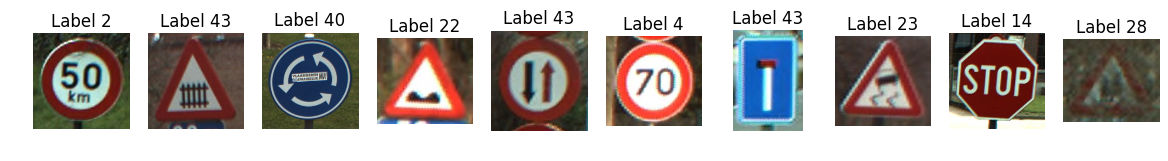

In [36]:
### Load the images and plot them here.
import glob
import re

# Get all the files to test
test_files  = [file for file in glob.glob("Traffic_signs_collected_data/*")]
test_labels = [re.search('(?<=Label)[0-9]+', file).group(0) for file in test_files]

# Load all the files
test_images = load_images(test_files)

# Display original
display_images(test_images, test_labels)


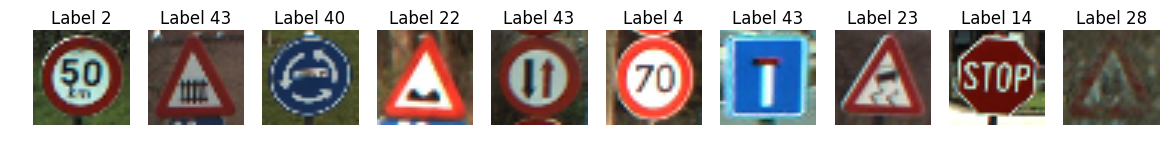

In [37]:
# Resize all the images to 32x32, which is the input of our network
test_images = np.array([cv2.resize(img, (32,32), interpolation = cv2.INTER_CUBIC) for img in test_images])

# Display resized images
display_images(test_images, test_labels)

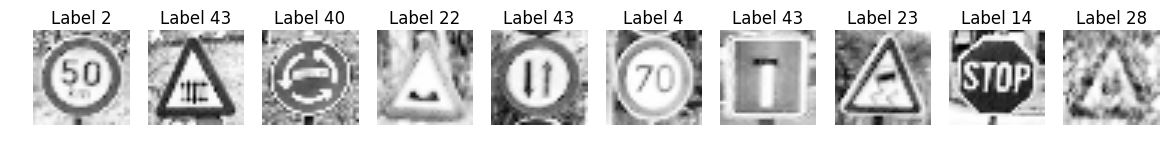

In [38]:
# Preprocess the images
test_images = preprocess_images(test_images)

# Display preprocessed images
display_images(test_images, test_labels, cmap='Greys_r')

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

I used 10 images, 3 out of 10 where not in the dataset provided so they will be difficult to classify.
Also the images had to be resized to 32x32 which can alter the quality of the image.

The roundabout sign has a sticker on it that make him looks like a No entry, it may be difficult to classify it.
Also the last sign (children crossing) his hidden behind some vegetation, it will be really hard to classify it.

As they are all well centered with good luminosity and clear sign, i still expect that the network to achieve pretty well.


In [39]:
### Run the predictions here.

# Reshape the image to match the network input, require the depth
test_images = np.reshape(test_images, (-1,test_images[0].shape[0],test_images[0].shape[1],1))

sess = tf.Session()

# Restore our model
save_file = './model.ckpt'
saver = tf.train.Saver()
saver.restore(sess, save_file)

# Run the prediction
label_prediction = sess.run(prediction, feed_dict={x: test_images, keep_prob: 1.0})
top_5 = sess.run(tf.nn.top_k(label_prediction,k=5))
sess.close()    


In [40]:
# Display results
# Get the sign names
signnames_file = open('./signnames.csv', 'r')
signnames = [line.strip().split(',')[-1] for line in signnames_file]
# Add the unknown
signnames.append('Unknown')
# Remove the 1st line, this is the header
signnames.pop(0)
signnames_file.close()    

signnames = np.array(signnames)

for idx in range(len(test_images)):
    label_pred = np.argmax(label_prediction[idx])
    print('Image {:d} : True Label={:2} {:25} => Prediction={:2} {}'.format(  idx
                                                                       , test_labels[idx],signnames[int(test_labels[idx])]
                                                                       , label_pred, signnames[label_pred]))


Image 0 : True Label=2  Speed limit (50km/h)      => Prediction= 2 Speed limit (50km/h)
Image 1 : True Label=43 Unknown                   => Prediction=30 Beware of ice/snow
Image 2 : True Label=40 Roundabout mandatory      => Prediction=40 Roundabout mandatory
Image 3 : True Label=22 Bumpy road                => Prediction=22 Bumpy road
Image 4 : True Label=43 Unknown                   => Prediction=40 Roundabout mandatory
Image 5 : True Label=4  Speed limit (70km/h)      => Prediction= 4 Speed limit (70km/h)
Image 6 : True Label=43 Unknown                   => Prediction=35 Ahead only
Image 7 : True Label=23 Slippery road             => Prediction=23 Slippery road
Image 8 : True Label=14 Stop                      => Prediction=14 Stop
Image 9 : True Label=28 Children crossing         => Prediction=28 Children crossing


### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

- If we keep the signs that was not in the dataset we get 7 out of 10 : 70% accuracy
- If we don't take into account the signs that was not in the dataset we get 7 out of 7 : 100% accuracy

So the model perform even better than with the test dataset were we got 97.05% accuracy. But our sample is really small and we should try it on a bigger set to get more accurate statistics.


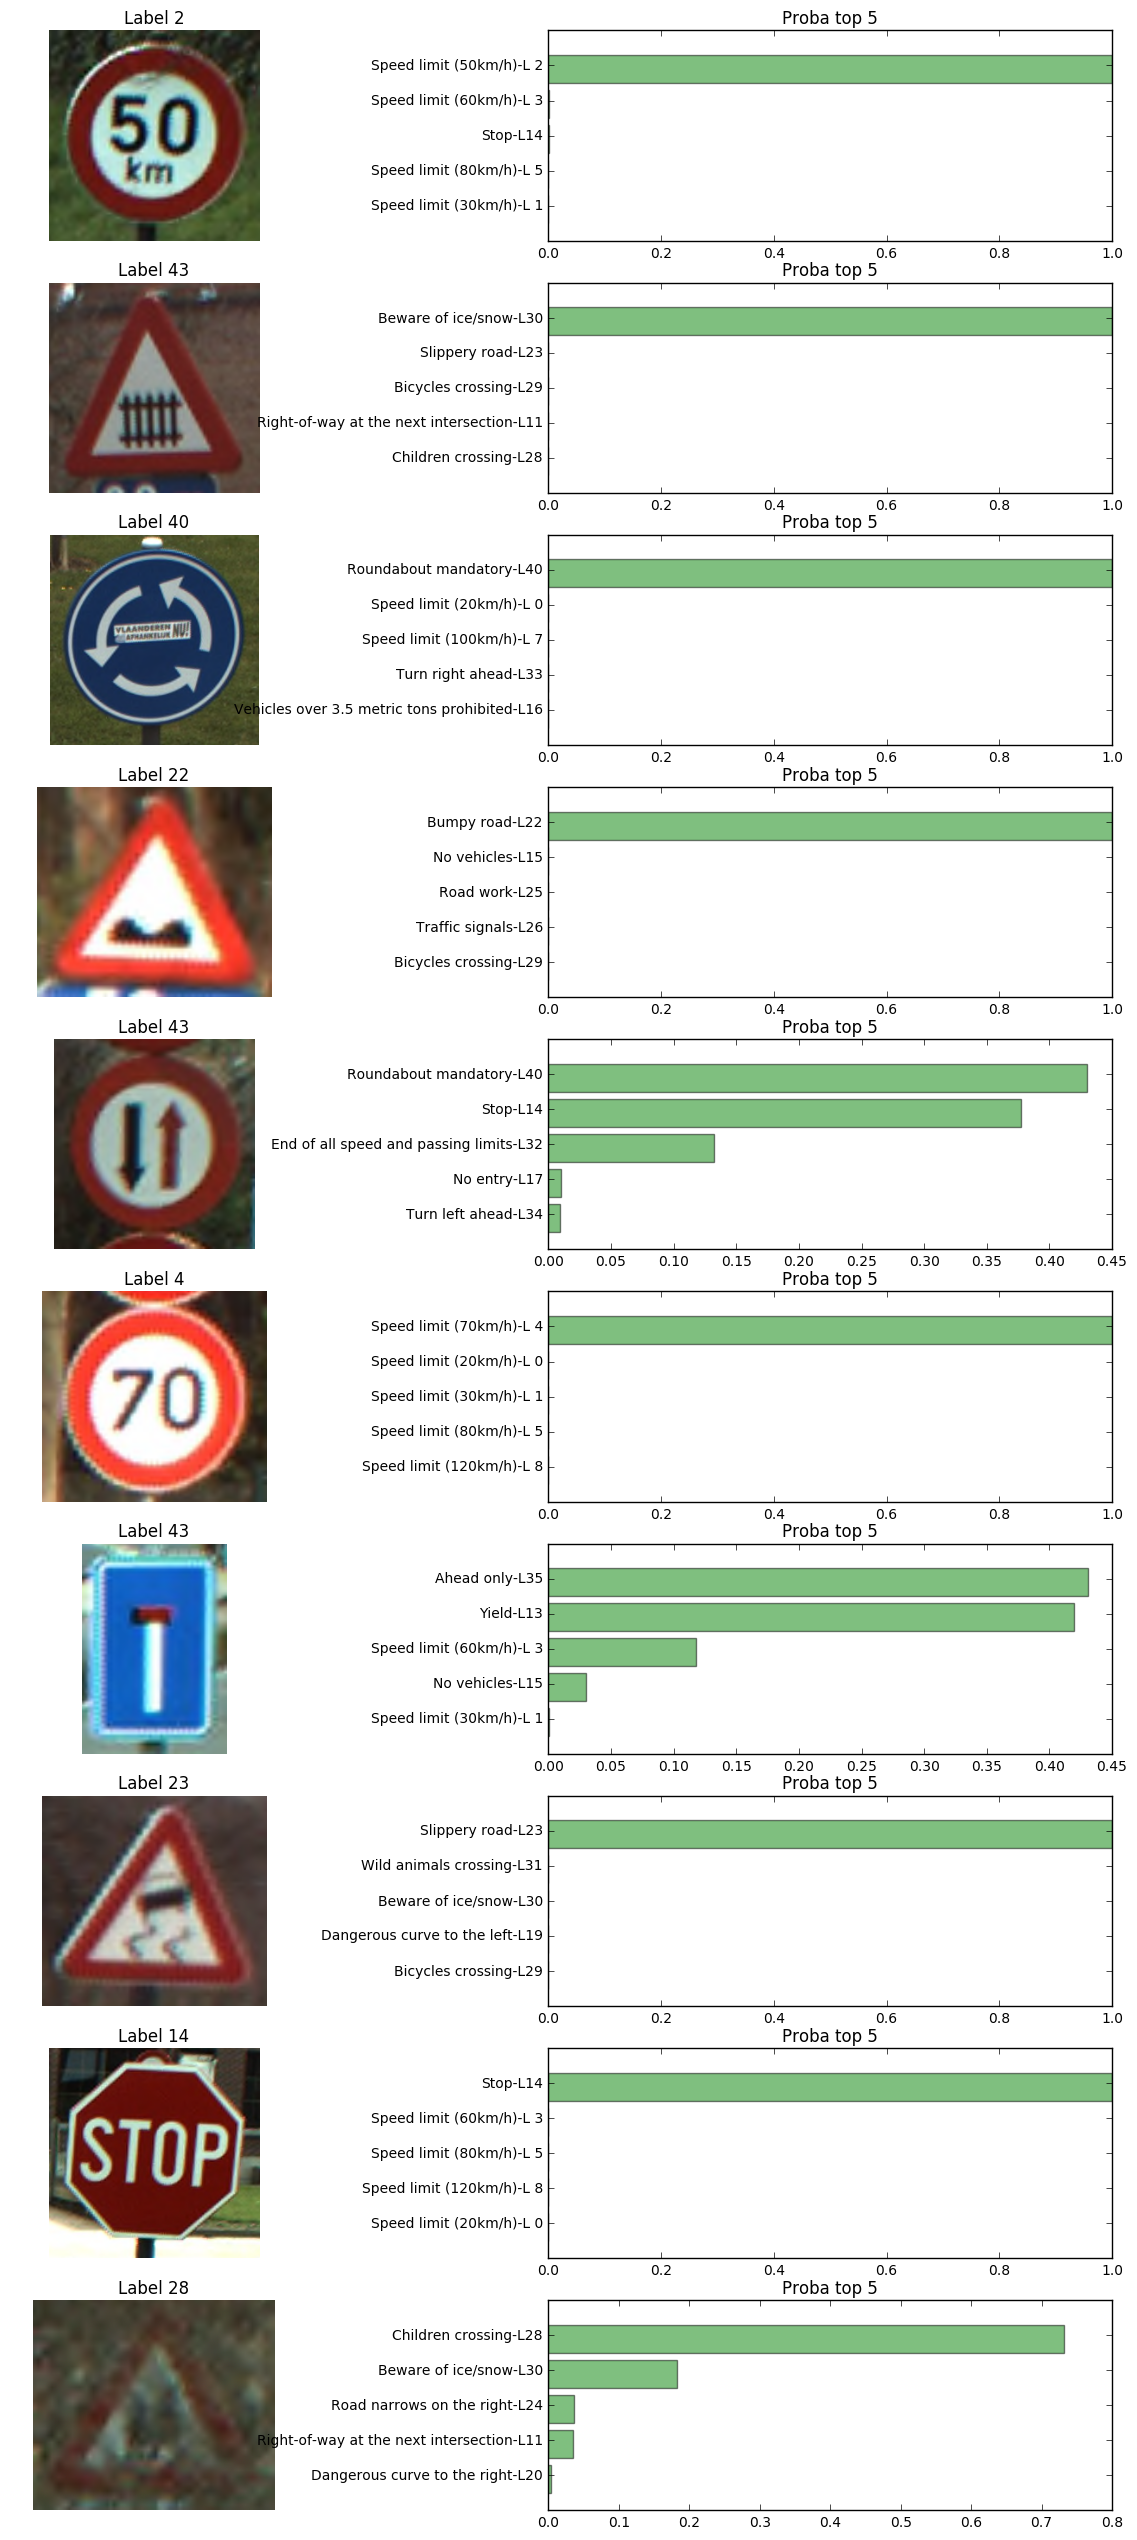

In [41]:
### Visualize the softmax probabilities here.
# Load all the files
test_images = load_images(test_files)

plt.figure(figsize=(16, 32))
i = 1
for idx, image in enumerate(test_images):
    plt.subplot(10, 2, i)  
    plt.axis('off')
    plt.title('Label {}'.format(test_labels[idx]))
    plt.imshow(image, cmap='brg_r')
    i += 1

    ax = plt.subplot(10, 2, i)  
    plt.barh([4.5,3.5,2.5,1.5,0.5], top_5.values[idx], facecolor='green', alpha=0.5)
    s = [ '{}-L{:2d}'.format(signnames[i],i) for i in top_5.indices[idx] ]
    s.append('')
    plt.yticks(range(6), reversed(s))
    plt.title('Proba top 5')
    i += 1

plt.show()

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

For all the sign from the dataset, the network is really certain of his choice even for the hardest sign almost completely hidden. I expected the network to missclassified this one.

For the sign that was not in the initial dataset we can see that it is sometimes really certain and for others the probability is really low.

To get more out of this test, we need to find more signs more 


> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.